/home/darkcover/.cache/pypoetry/virtualenvs/gan-oPyfrVEv-py3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 20/200 | D_loss: 16.3373 | G_loss: 0.4349
Epoch 40/200 | D_loss: 16.6018 | G_loss: 0.2736
Epoch 60/200 | D_loss: 16.9978 | G_loss: 0.1890
Epoch 80/200 | D_loss: 17.3162 | G_loss: 0.1435
Epoch 100/200 | D_loss: 17.5643 | G_loss: 0.1155
Epoch 120/200 | D_loss: 17.7638 | G_loss: 0.0967
Epoch 140/200 | D_loss: 17.9296 | G_loss: 0.0832
Epoch 160/200 | D_loss: 18.0656 | G_loss: 0.0730
Epoch 180/200 | D_loss: 18.1813 | G_loss: 0.0650
Epoch 200/200 | D_loss: 18.2876 | G_loss: 0.0586


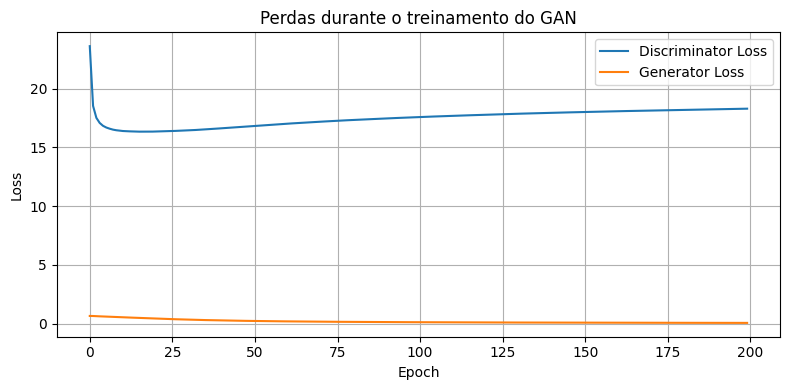

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
# ✅ GAN corrigido com saída linear no Generator + Reescalonamento para RSSI

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Input
import matplotlib.pyplot as plt

# ================================
# 1. Dados reais de entrada (X_real)
# ================================
df_real = pd.read_csv("/home/darkcover/Documentos/Gan/Data/df_simulated.csv")
X_real = df_real.iloc[:, :10].values.astype(np.float32)

n_features = X_real.shape[1]  # 10 WAPs
latent_dim = n_features       # 10

# ================================
# 2. Generator com saída linear
# ================================
def build_generator():
    model = Sequential([
        Input(shape=(latent_dim,)),
        layers.Dense(10, activation='relu'),
        layers.Dense(n_features)  # saída linear
    ])
    return model

# ================================
# 3. Discriminator padrão
# ================================
def build_discriminator():
    model = Sequential([
        Input(shape=(n_features,)),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# ================================
# 4. Compilar modelos
# ================================
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01))

discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01))

# ================================
# 5. Loop de Treinamento GAN
# ================================
epochs = 200
batch_size = 64
half_batch = batch_size // 2
d_losses, g_losses = [], []

for epoch in range(epochs):
    idx = np.random.randint(0, X_real.shape[0], half_batch)
    real_samples = X_real[idx]
    real_labels = np.ones((half_batch, 1))

    noise = np.random.uniform(-1, 1, (half_batch, latent_dim))
    fake_samples = generator.predict(noise, verbose=0)
    fake_labels = np.zeros((half_batch, 1))

    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs} | D_loss: {d_loss:.4f} | G_loss: {g_loss:.4f}")

# ================================
# 6. Plotar perdas
# ================================
plt.figure(figsize=(8, 4))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Perdas durante o treinamento do GAN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ================================
# 7. Gerar e salvar 40.000 vetores sintéticos com reescala
# ================================
n_generated = 40000
noise = np.random.uniform(-1, 1, size=(n_generated, latent_dim))
generated_rssi_raw = generator.predict(noise, verbose=1)

# Reescalonar saída para o intervalo [-110, -40]
min_val, max_val = -5, 6  # baseado na saída bruta inspecionada do generator
generated_rssi_scaled = (generated_rssi_raw - min_val) / (max_val - min_val)  # [0, 1]
generated_rssi = generated_rssi_scaled * 70 - 110  # [0, 1] -> [-110, -40]

columns = [f'WAP{str(i+1).zfill(3)}' for i in range(n_features)]
df_generated = pd.DataFrame(generated_rssi, columns=columns)
df_generated.to_csv("/home/darkcover/Documentos/Gan/Data/df_generated.csv", index=False)
print("✅ df_generated.csv salvo com sucesso com RSSI reescalonado")


In [2]:
df_generated.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,-101.080826,-95.122246,-61.591927,-69.942909,-98.806122,-69.984154,-58.406994,-103.894409,-59.054924,-53.798576
std,3.721496,5.582306,4.801888,4.058761,5.362015,5.593538,5.461499,4.638485,5.177657,4.403637
min,-119.798042,-121.087601,-74.251785,-78.320747,-125.339745,-83.382927,-75.716965,-127.375748,-74.352722,-64.975883
25%,-103.462393,-98.747686,-65.046963,-73.014538,-101.978445,-74.237289,-62.222774,-106.750360,-62.799996,-56.999655
50%,-100.831417,-94.596489,-62.097013,-70.292553,-97.954437,-70.692108,-58.440870,-103.497559,-59.288954,-54.253370
75%,-98.407310,-90.929621,-58.590088,-67.208202,-94.856026,-66.257195,-54.667275,-100.600874,-55.486526,-50.972099
max,-90.214233,-81.927582,-38.863472,-52.662590,-86.513390,-45.954102,-37.037506,-91.244034,-38.526031,-31.894577


In [3]:
df_generated.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010
0,-101.680542,-93.122894,-57.531372,-69.841049,-110.390877,-66.444107,-56.103634,-110.601898,-54.034050,-56.962589
1,-96.971207,-96.131027,-66.548798,-64.777039,-98.659515,-75.762924,-60.151566,-107.800919,-55.101212,-55.775333
2,-103.677208,-94.143150,-52.987450,-76.818741,-109.335533,-57.216469,-68.011215,-103.877563,-65.085846,-60.759701
3,-100.853058,-93.174034,-58.923382,-63.028152,-97.720078,-74.250076,-56.991161,-110.148399,-53.047901,-52.880329
4,-105.053619,-83.718155,-54.778122,-66.412033,-99.125359,-69.777405,-47.262100,-112.131454,-53.463127,-49.252331
